In [64]:
import os
import random
import numpy as np
import matplotlib as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.activations import linear, relu, sigmoid
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps
from IPython.display import display

Original dataset consists of two folders, each with 15,000 images. I used the `ulimit -n` and `ls | shuf -n 1000 | xargs -I {} cp "{}" ~target/` command to randomly pick 1000 images from each folder. They are stored in `negative-samples` and `positive-samples`

In [20]:
d1, d2 = 'data/negative-samples', 'data/positive-samples'
negative_images, positive_images = [], []

filenames1 = os.listdir(d1)
for filename in filenames1:
    
    if filename.endswith(".jpg"):
            
            img = Image.open(os.path.join(d1, filename))
            
            # resize image to 128x128 pixels
            img = ImageOps.fit(img, (128,128), method=Image.LANCZOS)
            # grayscale image
            img = ImageOps.grayscale(img)
            
            negative_images.append(img)

filenames2 = os.listdir(d2)
for filename in filenames2:
    
    if filename.endswith(".jpg"):
            
            img = Image.open(os.path.join(d2, filename))
            img = ImageOps.fit(img, (128,128), method=Image.LANCZOS)
            img = ImageOps.grayscale(img)
            
            positive_images.append(img)

In [22]:
print(len(negative_images))
print(len(positive_images))

1000
1000


In [23]:
# shuffle the images
random.shuffle(negative_images)
random.shuffle(positive_images)

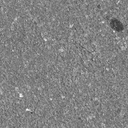

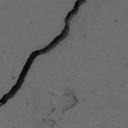

In [61]:
display(negative_images[0])     # first negative example
display(positive_images[0])     # first positive example

Now we turn these images into numpy arrays.

In [72]:
# X_n = np.stack([np.array(img) for img in negative_images])
# X_p = np.stack([np.array(img2) for img2 in positive_images])
# X = np.vstack((X_n, X_p))
# print("Shape of X:", X.shape)

# # first 1000 images are negative, and remaining 1000 images are positive
# y_n = [0 for i in range(1000)]
# y_p = [1 for j in range(1000)]
# # print("Length of y:", len(y))
# len(y_p)

Shape of X: (2000, 128, 128)


1000

In [106]:
X_n = np.stack([np.array(img) for img in negative_images])
X_p = np.stack([np.array(img2) for img2 in positive_images])
X = np.vstack((X_n, X_p))
print("Shape of X:", X.shape)

# store data into array, where each element is [(0 or 1), (2d array of image)]
df = []
for i in range(2000):
    # first 1000 images are negative, and remaining 1000 images are positive
    if i < 1000:
        df.append([0, X[i]])
    else:
        df.append([1, X[i]])

# shuffle
np.random.shuffle(df)
print("Lenght of df:", len(df))
print("First element in df:\n", df[0])

Shape of X: (2000, 128, 128)
Lenght of df: 2000
First element in df:
 [0, array([[163, 161, 162, ..., 161, 162, 161],
       [163, 160, 162, ..., 160, 161, 160],
       [162, 160, 161, ..., 159, 160, 159],
       ...,
       [156, 153, 150, ..., 155, 155, 156],
       [150, 147, 144, ..., 155, 154, 154],
       [145, 143, 143, ..., 154, 153, 153]], dtype=uint8)]


In [ ]:
X_train, X_remain, y_n_train, y_n_remain = train_test_split(X_n, y_n, test_size=0.4, random_state=42)
X_n_cv, X_n_test, y_n_cv, y_n_test = train_test_split(X_n_remain, y_n_remain, test_size=0.5, random_state=42)

Split training data 60-20-20 (train, cv, test)

In [78]:
# split negative samples
X_n_train, X_n_remain, y_n_train, y_n_remain = train_test_split(X_n, y_n, test_size=0.4, random_state=42)
X_n_cv, X_n_test, y_n_cv, y_n_test = train_test_split(X_n_remain, y_n_remain, test_size=0.5, random_state=42)
# split positive samples
X_p_train, X_p_remain, y_p_train, y_p_remain = train_test_split(X_p, y_p, test_size=0.4, random_state=42)
X_p_cv, X_p_test, y_p_cv, y_p_test = train_test_split(X_p_remain, y_p_remain, test_size=0.5, random_state=42)

print("X negative training:", X_n_train.shape[0])
print("y negative training:", len(y_n_train))
print("X negative cv:", X_n_cv.shape[0])
print("y negative cv:", len(y_n_cv))
print("X negative test:", X_n_test.shape[0])
print("y negative test:", len(y_n_test))
print()
print("X positive training:", X_p_train.shape[0])
print("y positive training:", len(y_p_train))
print("X positive cv:", X_p_cv.shape[0])
print("y positive cv:", len(y_p_cv))
print("X positive test:", X_p_test.shape[0])
print("y positive test:", len(y_p_test))

X negative training: 600
y negative training: 600
X negative cv: 200
y negative cv: 200
X negative test: 200
y negative test: 200

X positive training: 600
y positive training: 600
X positive cv: 200
y positive cv: 200
X positive test: 200
y positive test: 200


In [ ]:
[ [0, image], [1, image], [0, image] ]
# store like this and shuffle

In [ ]:
model = Sequential(
    [
        tf.keras.Input(shape=(128,128)),
        
        Dense
    ]
)